In [413]:
import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
mine = pd.read_csv('C://Users//garyp//Desktop//Python//myimdbratings.csv',encoding = "ISO-8859-1")
movies= pd.read_csv('C://Users//garyp//Desktop//Python//IMDB Movies.csv')
ratings= pd.read_csv('C://Users//garyp//Desktop//Python//IMDB Ratings.csv')
names= pd.read_csv('C://Users//garyp//Desktop//Python//IMDB Names.csv')
rot= pd.read_csv('C://Users//garyp//Desktop//Python//rotten_tomatoes_movies.csv')
lb1= pd.read_csv('C://Users//garyp//Desktop//Python//ratings_export.csv')
lb2= pd.read_csv('C://Users//garyp//Desktop//Python//movie_data.csv')

#REMOVING DUPLICATES for ease. For IMDB/ROT I'm sorting high to low for number of votes and deleting
movies=movies.sort_values('votes',ascending=False)
movies.drop_duplicates('original_title',keep='first',inplace=True)
movies=movies.reset_index(drop=True)
mine=mine.sort_values('Num Votes',ascending=False)
mine.drop_duplicates('Title',keep='first',inplace=True)
mine=mine.reset_index(drop=True)
rot=rot.sort_values('tomatometer_count',ascending=False)
rot.drop_duplicates('movie_title',keep='first',inplace=True)
rot=rot.reset_index(drop=True)

C:\Users\garyp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [414]:
#Rotten tomatoes data
#Really tedious. Foreign movies show up like Open your eyes (Abre Los Ojos)
#so have to data filter, searching for open brackets, splitting into two columns, getting capitalisations right etc..
#Still not perfect but this will do for now. Am just gonna capitalize everything afterwards
#Making titles of english and original, and then mapping this to the LB table (before merging to imdb) to have both available in final
#Others like 12 angry men(twelve angry men) which just dont match IMDB. i will do a sort for >100000 rating films and manually
#change a few that RT is mapping wrong
rot['movie_title']=rot['movie_title'].apply(lambda x:x.split(' ('))
df=pd.DataFrame(rot["movie_title"].to_list())
for i in range(len(df)):
    if df.iloc[i][1]==None:
        df.iloc[i][2]=df.iloc[i][0]
    else:
        df.iloc[i][2]=df.iloc[i][1][:-1]
rot['movie_title']=df[2]
rot['english_title']=df[0]

In [415]:
#letterboxd data came in two files. movie_id with ratings by each of the top 4000 members(lb1)
#second(lb2) is matching the movie id to actual movie name
#so i do groupby movie_id mean to get values. I also seperately do count, and then filter out any less than 250
lbav =lb1.groupby('movie_id').mean()
lbcount =lb1.groupby('movie_id').count()
lb1=pd.merge(lbav,lbcount,how='left',on='movie_id')
lb1.columns=['rating','count','count2','count3']

#averaging letterboxd ratings to an average rating
lb=pd.merge(lb1,lb2,how='left',on='movie_id')
lb=lb[lb['count']>250]
lb=lb.sort_values('count',ascending=False)
lb.drop_duplicates('movie_title',keep='first',inplace=True)
lb=lb.reset_index(drop=True)
lb=pd.merge(lb,rot,how='left',left_on='movie_title',right_on='english_title')

In [416]:
#grabbing just columns that matter
movies=movies[['imdb_title_id','original_title','year','genre','duration','country','language','director']]
ratings=ratings[['imdb_title_id','weighted_average_vote','total_votes','votes_10']]
rot=rot[['movie_title','tomatometer_rating','tomatometer_count']]
mine=mine[['Title','Your Rating']]
lb=lb[['movie_title_y','english_title','rating']]
lb.columns=['movie_title','english_title','rating']
#print(movies.head())
#print(ratings.head())
#print(rot.head())
#print(mine.head())
#print(lb.head())

In [417]:
#capitalising everything for max probability of a match. had to use string on lb
movies['original_title']=movies['original_title'].apply(lambda x:x.upper())
mine['Title']=mine['Title'].apply(lambda x:x.upper())
rot['movie_title']=rot['movie_title'].apply(lambda x:str(x).upper())
lb['movie_title']=lb['movie_title'].apply(lambda x:str(x).upper())

In [418]:
#merging
mov=pd.merge(movies,ratings,on='imdb_title_id',how='left')
mov=pd.merge(mov,rot,left_on='original_title',right_on='movie_title',how='left')
mov=pd.merge(mov,mine,left_on='original_title',right_on='Title',how='left')
mov=pd.merge(mov,lb,left_on='original_title',right_on='movie_title',how='left')

In [419]:
#************save point
copy=mov.copy()

In [420]:
#*********** regain point
mov=copy.copy()

In [421]:
#Getting rid of duplicated column titles, and getting columns in order of importance
mov=mov[['original_title','english_title','year','genre','language','country','duration','director','weighted_average_vote','total_votes','votes_10',
     'tomatometer_rating','tomatometer_count','rating','Your Rating']]
mov.columns=['Title','English_Title','Year','Genre','Language','Country','Duration','Director','IMDB_Rating','IMDB_total_votes','10/10pct',
     'RT_rating','RT_count','LB_rating','My_Rating']

In [422]:
#only movies >20000 IMDB votes
mov=mov[mov['IMDB_total_votes']>20000]
#I wont filter out RT count just yet, as I want to see whats incorrectly mapping
#mov=mov[mov['RT_count']>10]

In [423]:
#splitting up genres
mov['Genre']=mov['Genre'].apply(lambda x:x.split(', '))
df=pd.DataFrame(mov["Genre"].to_list(), columns=['Genre1', 'Genre2','Genre3'])
#have to now reset index to make sure numbers match with df
mov.reset_index(inplace=True)
mov.drop('index',axis=1,inplace=True)

In [424]:
mov.insert(2,'Genre1',df['Genre1'])
mov.insert(3,'Genre2',df['Genre2'])
mov.insert(4,'Genre3',df['Genre3'])
mov.drop('Genre',axis=1,inplace=True)
#removing indian and turkey films
mov=mov[(mov['Country']!='Turkey') & (mov['Country']!='India')]
mov.reset_index(inplace=True)
mov.drop('index',axis=1,inplace=True)

In [425]:
#rt rating in normal terms and 10/10 in percentage terms
mov['RT_rating']=mov['RT_rating']/10
mov['10/10pct']=mov['10/10pct']/mov['IMDB_total_votes']
mov

,Title,English_Title,Genre1,Genre2,Genre3,Year,Language,Country,Duration,Director,IMDB_Rating,IMDB_total_votes,10/10pct,RT_rating,RT_count,LB_rating,My_Rating
0,THE SHAWSHANK REDEMPTION,The Shawshank Redemption,Drama,None,None,1994,English,USA,142,Frank Darabont,9.3,2278845,0.552506,9.1,75.0,8.562138,9.0
1,THE DARK KNIGHT,The Dark Knight,Action,Crime,Drama,2008,"English, Mandarin","USA, UK",152,Christopher Nolan,9.0,2241615,0.448984,9.4,340.0,8.583418,8.0
2,INCEPTION,Inception,Action,Adventure,Sci-Fi,2010,"English, Japanese, French","USA, UK",148,Christopher Nolan,8.8,2002816,0.351177,8.7,357.0,8.269270,7.0
3,FIGHT CLUB,Fight Club,Drama,None,None,1999,English,"USA, Germany",139,David Fincher,8.8,1807440,0.344643,7.9,173.0,8.407168,9.0
4,PULP FICTION,Pulp Fiction,Crime,Drama,None,1994,"English, Spanish, French",USA,154,Quentin Tarantino,8.9,1780147,0.370740,9.2,106.0,8.847307,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5510,YOGI BEAR,Yogi Bear,Animation,Adventure,Comedy,2010,English,"USA, New Zealand",81,Eric Brevig,4.6,20027,0.067958,1.3,104.0,2.869281,NaN
5511,CURLY SUE,NaN,Comedy,Drama,Family,1991,English,USA,101,John Hughes,5.9,20025,0.085693,1.3,15.0,NaN,NaN
5512,CAPTAIN RON,NaN,Adventure,Comedy,None,1992,English,USA,90,Thom Eberhardt,5.8,20023,0.085602,2.3,22.0,NaN,NaN
5513,WHAT MEN WANT,What Men Want,Comedy,Fantasy,Romance,2019,"English, Mandarin",USA,117,Adam Shankman,5.2,20016,0.053957,4.2,146.0,4.491228,NaN


In [426]:
#Rashomon mapped wrongly so setting my value to 10.
#After this i had to do tedious look up values on every film ive ranked that had missing values for LB or RT
#Took ages, and then took a while to figure out how to map it to my values, but I FINALLY have it.
# Going forward there will be issues with foreign titles , but hopefully most get caught from RT formula.
# As you find new movies that are missing for LB or RT, can add them to the sheet
mov.loc[(mov[mov['Title']=='RASHÔMON'].index.values),'My_Rating']=10
fillblanks=pd.read_excel('C://Users//garyp//Desktop//Python//moviesmissingdata.xlsx')
for i in range(len(fillblanks)):
    mov.loc[(mov[mov['Title']==fillblanks.iloc[i]['Title']].index.values),'RT_rating']=fillblanks.iloc[i]['RT_rating']
    mov.loc[(mov[mov['Title']==fillblanks.iloc[i]['Title']].index.values),'RT_count']=fillblanks.iloc[i]['RT_count']
    mov.loc[(mov[mov['Title']==fillblanks.iloc[i]['Title']].index.values),'LB_rating']=fillblanks.iloc[i]['LB_rating']

In [427]:
#Adding categories and Language Variables
genrelist=['Action','Adventure','Animation','Biography','Comedy','Crime','Drama','Family','Fantasy','Film-Noir','History','Horror','Music','Musical','Mystery','Romance','Sci-Fi','Sport','Thriller','War','Western']
genre1=pd.get_dummies(mov['Genre1'])
genre2=pd.get_dummies(mov['Genre2'])
genre3=pd.get_dummies(mov['Genre3'])
#add blank columns too
for i in genrelist:
    if i in genre1.columns:
        pass
    else:
        genre1.insert(0,i,0)
    if i in genre2.columns:
        pass
    else:
        genre2.insert(0,i,0)
    if i in genre3.columns:
        pass
    else:
        genre3.insert(0,i,0)
genres=genre1+genre2+genre3
mov=pd.concat([mov,genres],axis=1)
mov['Musical']=mov['Musical']+mov['Music']
mov.drop('Music',axis=1,inplace=True)

In [428]:
lang=pd.get_dummies(mov['Language'].apply(lambda x:x.split(',')[0]))
lang['Chinese']=lang['Mandarin']+lang['Cantonese']
lang['Other']=lang.sum(axis=1)-lang['English']-lang['French']-lang['German']-lang['Italian']-lang['Japanese']-lang['Korean']-lang['Spanish']-lang['Chinese']
lang=lang[['English','French','German','Italian','Japanese','Korean','Spanish','Chinese','Other']]
mov=pd.concat([mov,lang],axis=1)
mov.drop('Genre2',axis=1,inplace=True)
mov.drop('Genre3',axis=1,inplace=True)
mov.drop('Language',axis=1,inplace=True)
mov.drop('Country',axis=1,inplace=True)
#Deleting one bad value where Bad Education shows up as TV MOVIE 2019
mov=mov[mov['Year']!='TV Movie 2019']
mov

,Title,English_Title,Genre1,Year,Duration,Director,IMDB_Rating,IMDB_total_votes,10/10pct,RT_rating,...,Western,English,French,German,Italian,Japanese,Korean,Spanish,Chinese,Other
0,THE SHAWSHANK REDEMPTION,The Shawshank Redemption,Drama,1994,142,Frank Darabont,9.3,2278845,0.552506,9.1,...,0,1,0,0,0,0,0,0,0,0
1,THE DARK KNIGHT,The Dark Knight,Action,2008,152,Christopher Nolan,9.0,2241615,0.448984,9.4,...,0,1,0,0,0,0,0,0,0,0
2,INCEPTION,Inception,Action,2010,148,Christopher Nolan,8.8,2002816,0.351177,8.7,...,0,1,0,0,0,0,0,0,0,0
3,FIGHT CLUB,Fight Club,Drama,1999,139,David Fincher,8.8,1807440,0.344643,7.9,...,0,1,0,0,0,0,0,0,0,0
4,PULP FICTION,Pulp Fiction,Crime,1994,154,Quentin Tarantino,8.9,1780147,0.370740,9.2,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5510,YOGI BEAR,Yogi Bear,Animation,2010,81,Eric Brevig,4.6,20027,0.067958,1.3,...,0,1,0,0,0,0,0,0,0,0
5511,CURLY SUE,NaN,Comedy,1991,101,John Hughes,5.9,20025,0.085693,1.3,...,0,1,0,0,0,0,0,0,0,0
5512,CAPTAIN RON,NaN,Adventure,1992,90,Thom Eberhardt,5.8,20023,0.085602,2.3,...,0,1,0,0,0,0,0,0,0,0
5513,WHAT MEN WANT,What Men Want,Comedy,2019,117,Adam Shankman,5.2,20016,0.053957,4.2,...,0,1,0,0,0,0,0,0,0,0


In [429]:
train=mov[mov['My_Rating'].isna()==False]
train.reset_index(drop=True,inplace=True)
train

,Title,English_Title,Genre1,Year,Duration,Director,IMDB_Rating,IMDB_total_votes,10/10pct,RT_rating,...,Western,English,French,German,Italian,Japanese,Korean,Spanish,Chinese,Other
0,THE SHAWSHANK REDEMPTION,The Shawshank Redemption,Drama,1994,142,Frank Darabont,9.3,2278845,0.552506,9.1,...,0,1,0,0,0,0,0,0,0,0
1,THE DARK KNIGHT,The Dark Knight,Action,2008,152,Christopher Nolan,9.0,2241615,0.448984,9.4,...,0,1,0,0,0,0,0,0,0,0
2,INCEPTION,Inception,Action,2010,148,Christopher Nolan,8.8,2002816,0.351177,8.7,...,0,1,0,0,0,0,0,0,0,0
3,FIGHT CLUB,Fight Club,Drama,1999,139,David Fincher,8.8,1807440,0.344643,7.9,...,0,1,0,0,0,0,0,0,0,0
4,PULP FICTION,Pulp Fiction,Crime,1994,154,Quentin Tarantino,8.9,1780147,0.370740,9.2,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,DU RIFIFI CHEZ LES HOMMES,NaN,Crime,1955,118,Jules Dassin,8.2,26468,0.183807,9.2,...,0,0,1,0,0,0,0,0,0,0
472,LIFEBOAT,Lifeboat,Drama,1944,97,Alfred Hitchcock,7.6,25855,0.125778,9.2,...,0,1,0,0,0,0,0,0,0,0
473,IN A LONELY PLACE,In a Lonely Place,Drama,1950,94,Nicholas Ray,8.0,25368,0.147903,9.8,...,0,1,0,0,0,0,0,0,0,0
474,WAKING NED,NaN,Comedy,1998,91,Kirk Jones,7.3,24727,0.113196,8.4,...,0,1,0,0,0,0,0,0,0,0


In [430]:
#check no missing data
#train[train['RT_rating'].isna()]
train[train['LB_rating'].isna()]

,Title,English_Title,Genre1,Year,Duration,Director,IMDB_Rating,IMDB_total_votes,10/10pct,RT_rating,...,Western,English,French,German,Italian,Japanese,Korean,Spanish,Chinese,Other


In [ ]:
****************************************************************************Analysis***************************************************************

In [431]:
#Correlation of ratings
#Unlike before, actually lowest correlation with letterboxd. IMDB and RT very high correlation too
train[['IMDB_Rating','RT_rating','LB_rating','My_Rating']].corr()

,IMDB_Rating,RT_rating,LB_rating,My_Rating
IMDB_Rating,1.000000,0.290067,0.228067,0.514341
RT_rating,0.290067,1.000000,0.094401,0.233986
LB_rating,0.228067,0.094401,1.000000,0.209397
My_Rating,0.514341,0.233986,0.209397,1.000000


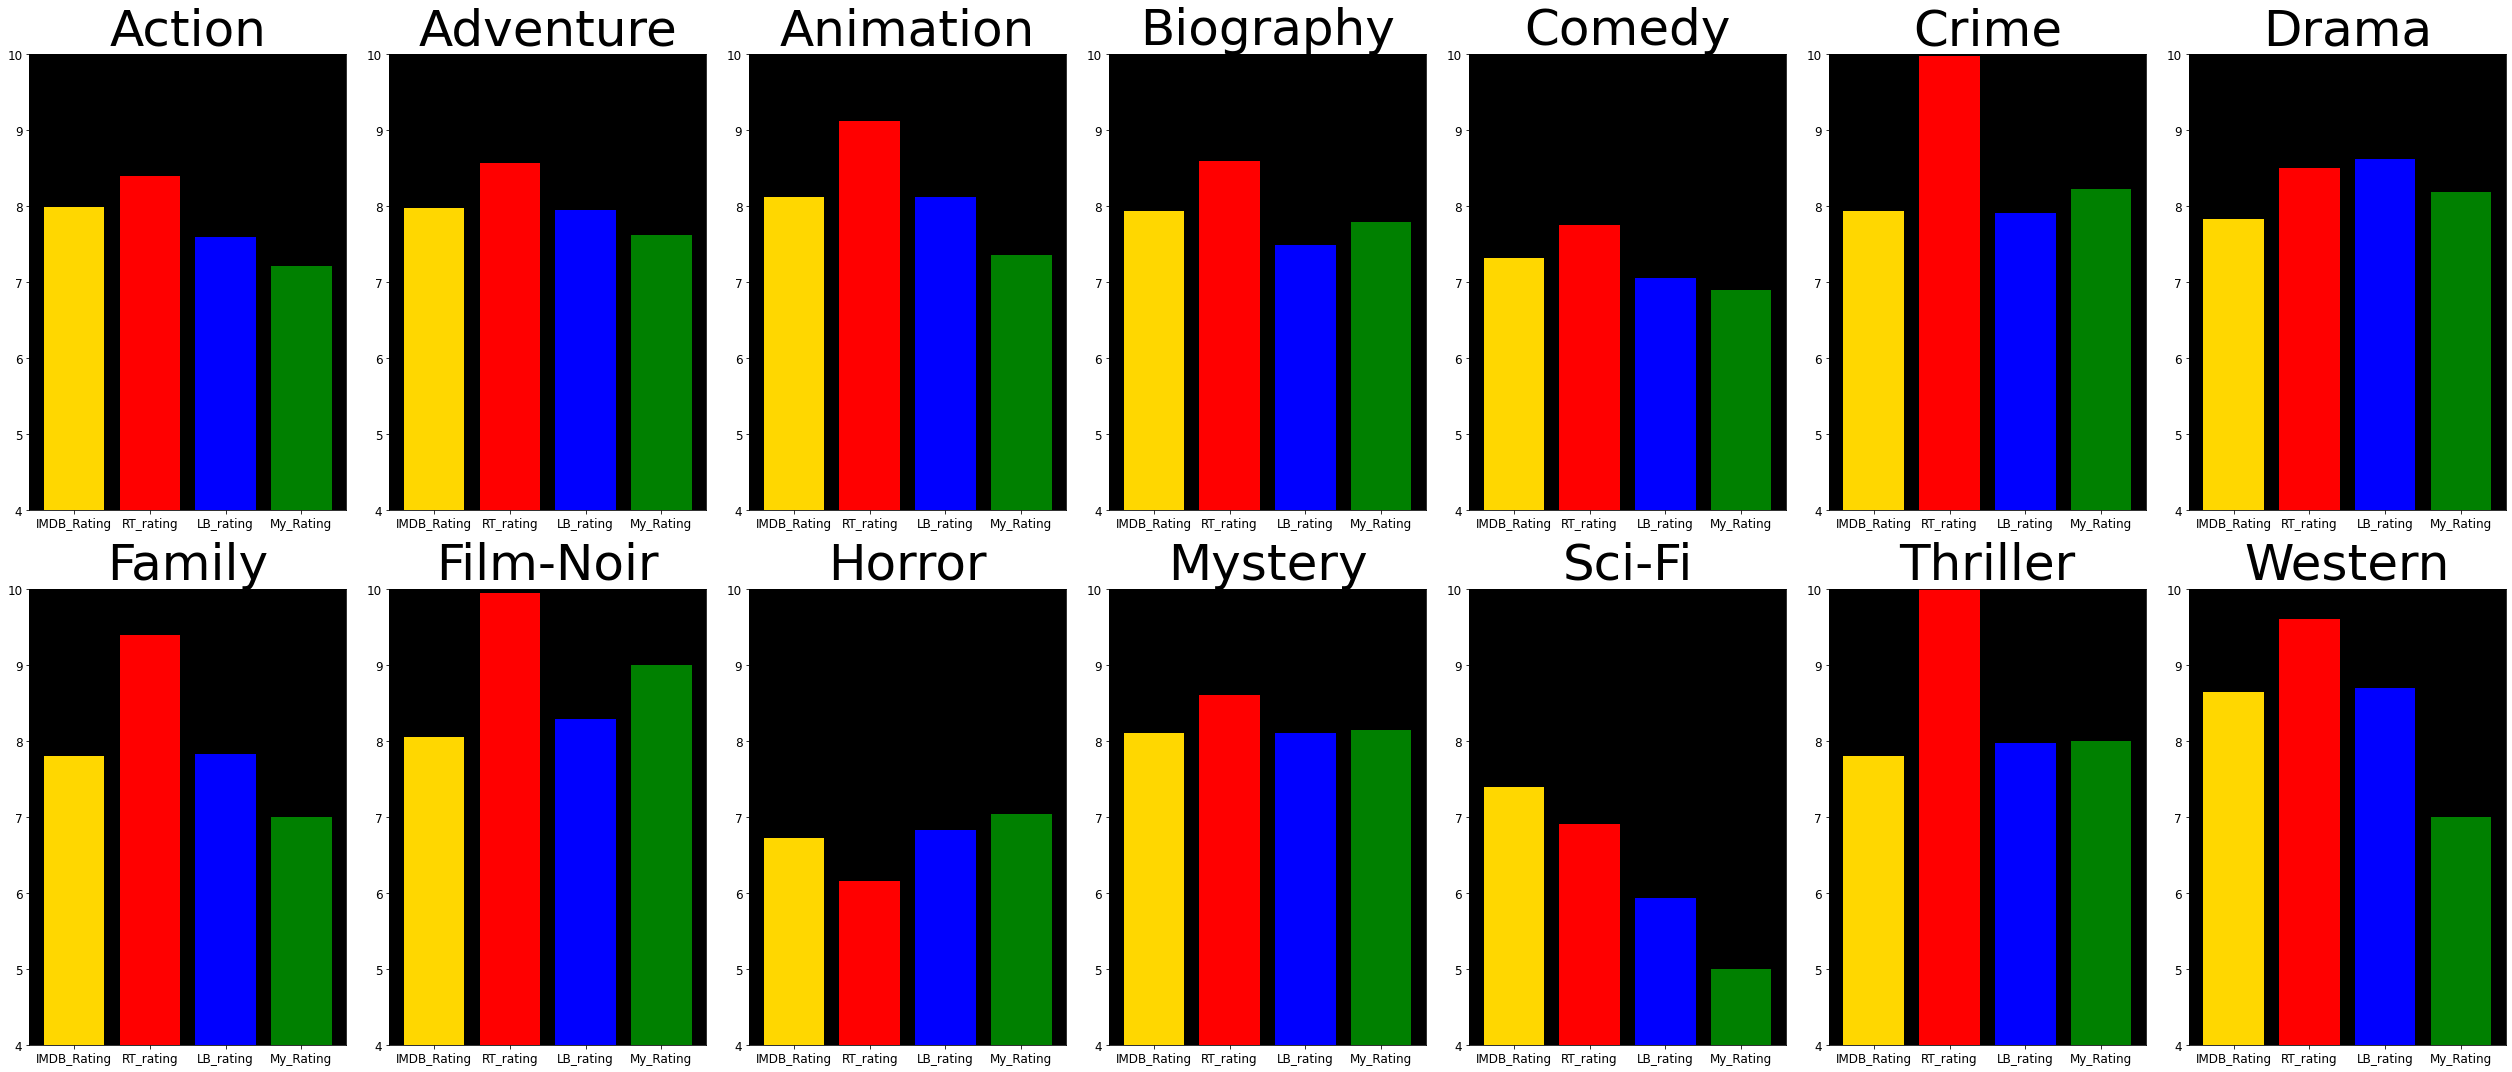

In [432]:
import matplotlib.pyplot as plt
x=train.groupby('Genre1').mean()[['IMDB_Rating','RT_rating','LB_rating','My_Rating']].T
y=list(x.columns)
y=[y[0:7],y[7:]]
fig,axes=plt.subplots(2,7,figsize=(35,15))
for i in range(2):
    for j in range(7):
        axes[i][j].bar(x.index,x[y[i][j]],color=['gold','red','blue','green'])
        axes[i][j].set_title(y[i][j],fontsize=50)
        axes[i][j].set_ylim(4,10)
        axes[i][j].set_facecolor('black')
        axes[i][j].tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()

In [433]:
#**************REGRESSION
from sklearn.linear_model import LinearRegression
from sklearn import metrics
train.columns

Index(['Title', 'English_Title', 'Genre1', 'Year', 'Duration', 'Director',
       'IMDB_Rating', 'IMDB_total_votes', '10/10pct', 'RT_rating', 'RT_count',
       'LB_rating', 'My_Rating', 'Action', 'Adventure', 'Animation',
       'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy',
       'Film-Noir', 'History', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'English', 'French',
       'German', 'Italian', 'Japanese', 'Korean', 'Spanish', 'Chinese',
       'Other'],
      dtype='object')

In [434]:
X=train[['Year', 'Duration','IMDB_Rating','10/10pct','RT_rating','LB_rating','Action','Adventure','Animation','Biography','Comedy','Crime','Drama','Family','Fantasy','Film-Noir','History',
         'Horror','Musical','Mystery','Romance','Sci-Fi','Sport','Thriller','War','Western','English','French','German', 'Italian', 'Japanese', 'Korean', 'Spanish', 'Chinese','Other']]
y=train[['My_Rating']]

In [435]:
lm=LinearRegression()
lm.fit(X,y)
print('RSquare:',lm.score(X,y))
print('Intercept:',lm.intercept_)
coeffs=pd.DataFrame(lm.coef_)
coeffs.columns=X.columns

RSquare: 0.41803012416457863
Intercept: [3.85418137]


In [436]:
coeffs_genre=coeffs[['Action','Adventure','Animation','Biography','Comedy','Crime','Drama','Family','Fantasy',
        'Film-Noir','History','Horror','Musical','Mystery','Romance','Sci-Fi','Sport','Thriller','War','Western']].T
coeffs_lang=coeffs[['English','French','German','Italian','Japanese','Korean','Spanish','Chinese','Other']].T
coeffs_other=coeffs[['Year','Duration','IMDB_Rating','RT_rating','LB_rating','10/10pct']].T

Text(0.5, 1.0, 'Genre Coefficients')

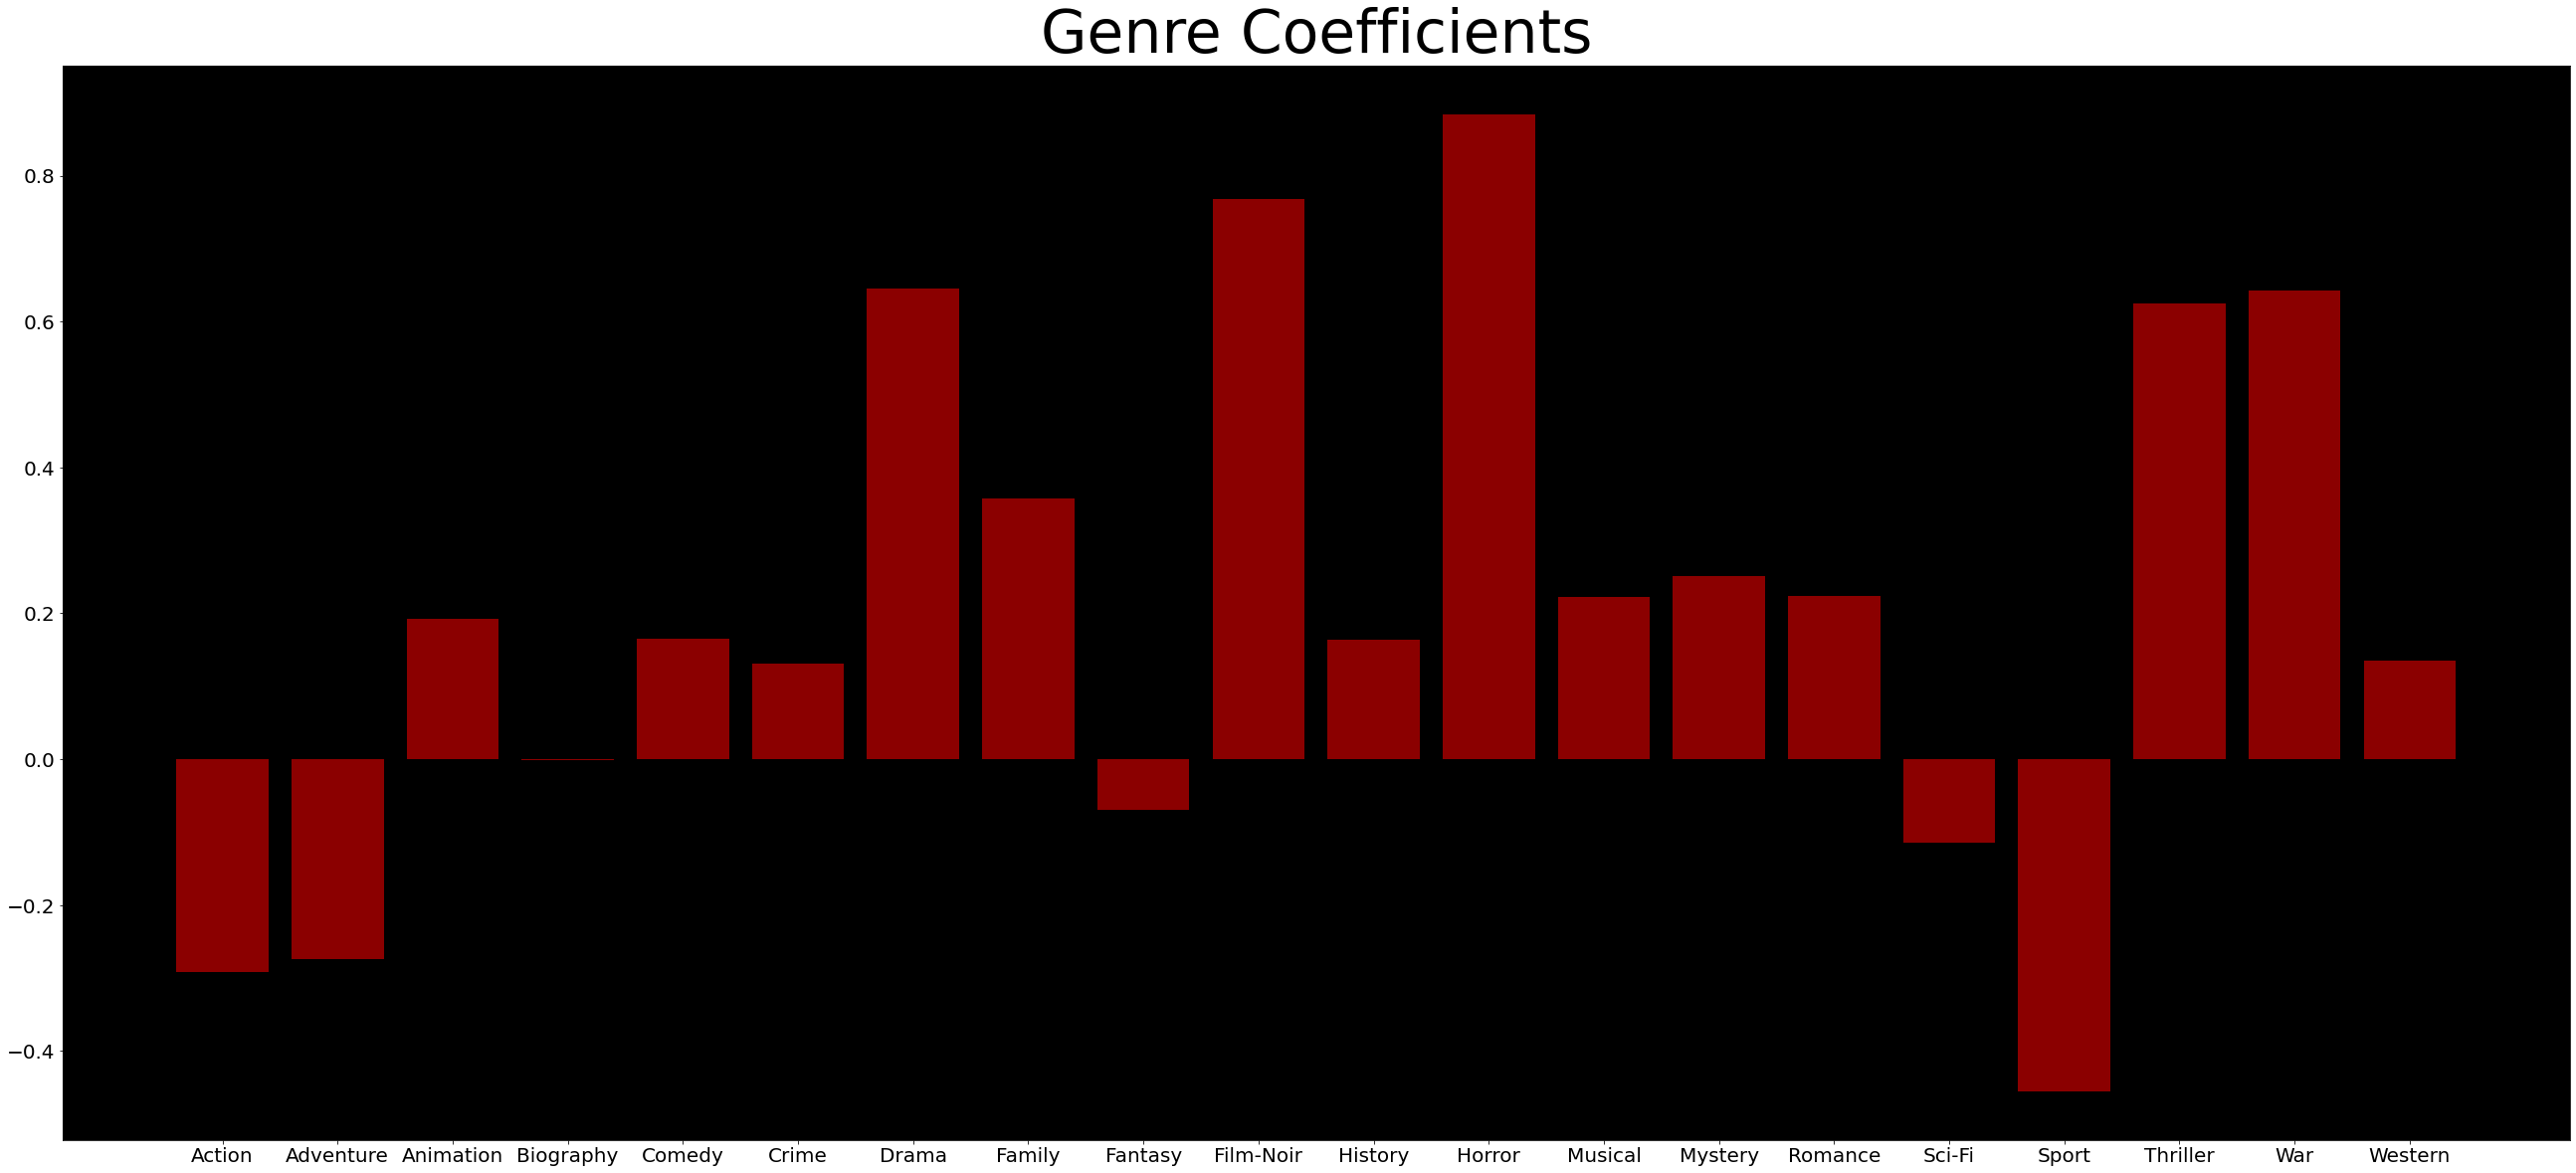

In [437]:
fig=plt.figure(figsize=(35,15))
ax=fig.add_axes([0,0,1,1])
ax.bar(coeffs_genre.index,coeffs_genre[0],color='darkred')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_facecolor('black')
ax.set_title('Genre Coefficients',fontsize=60)

Text(0.5, 1.0, 'Language Coefficients')

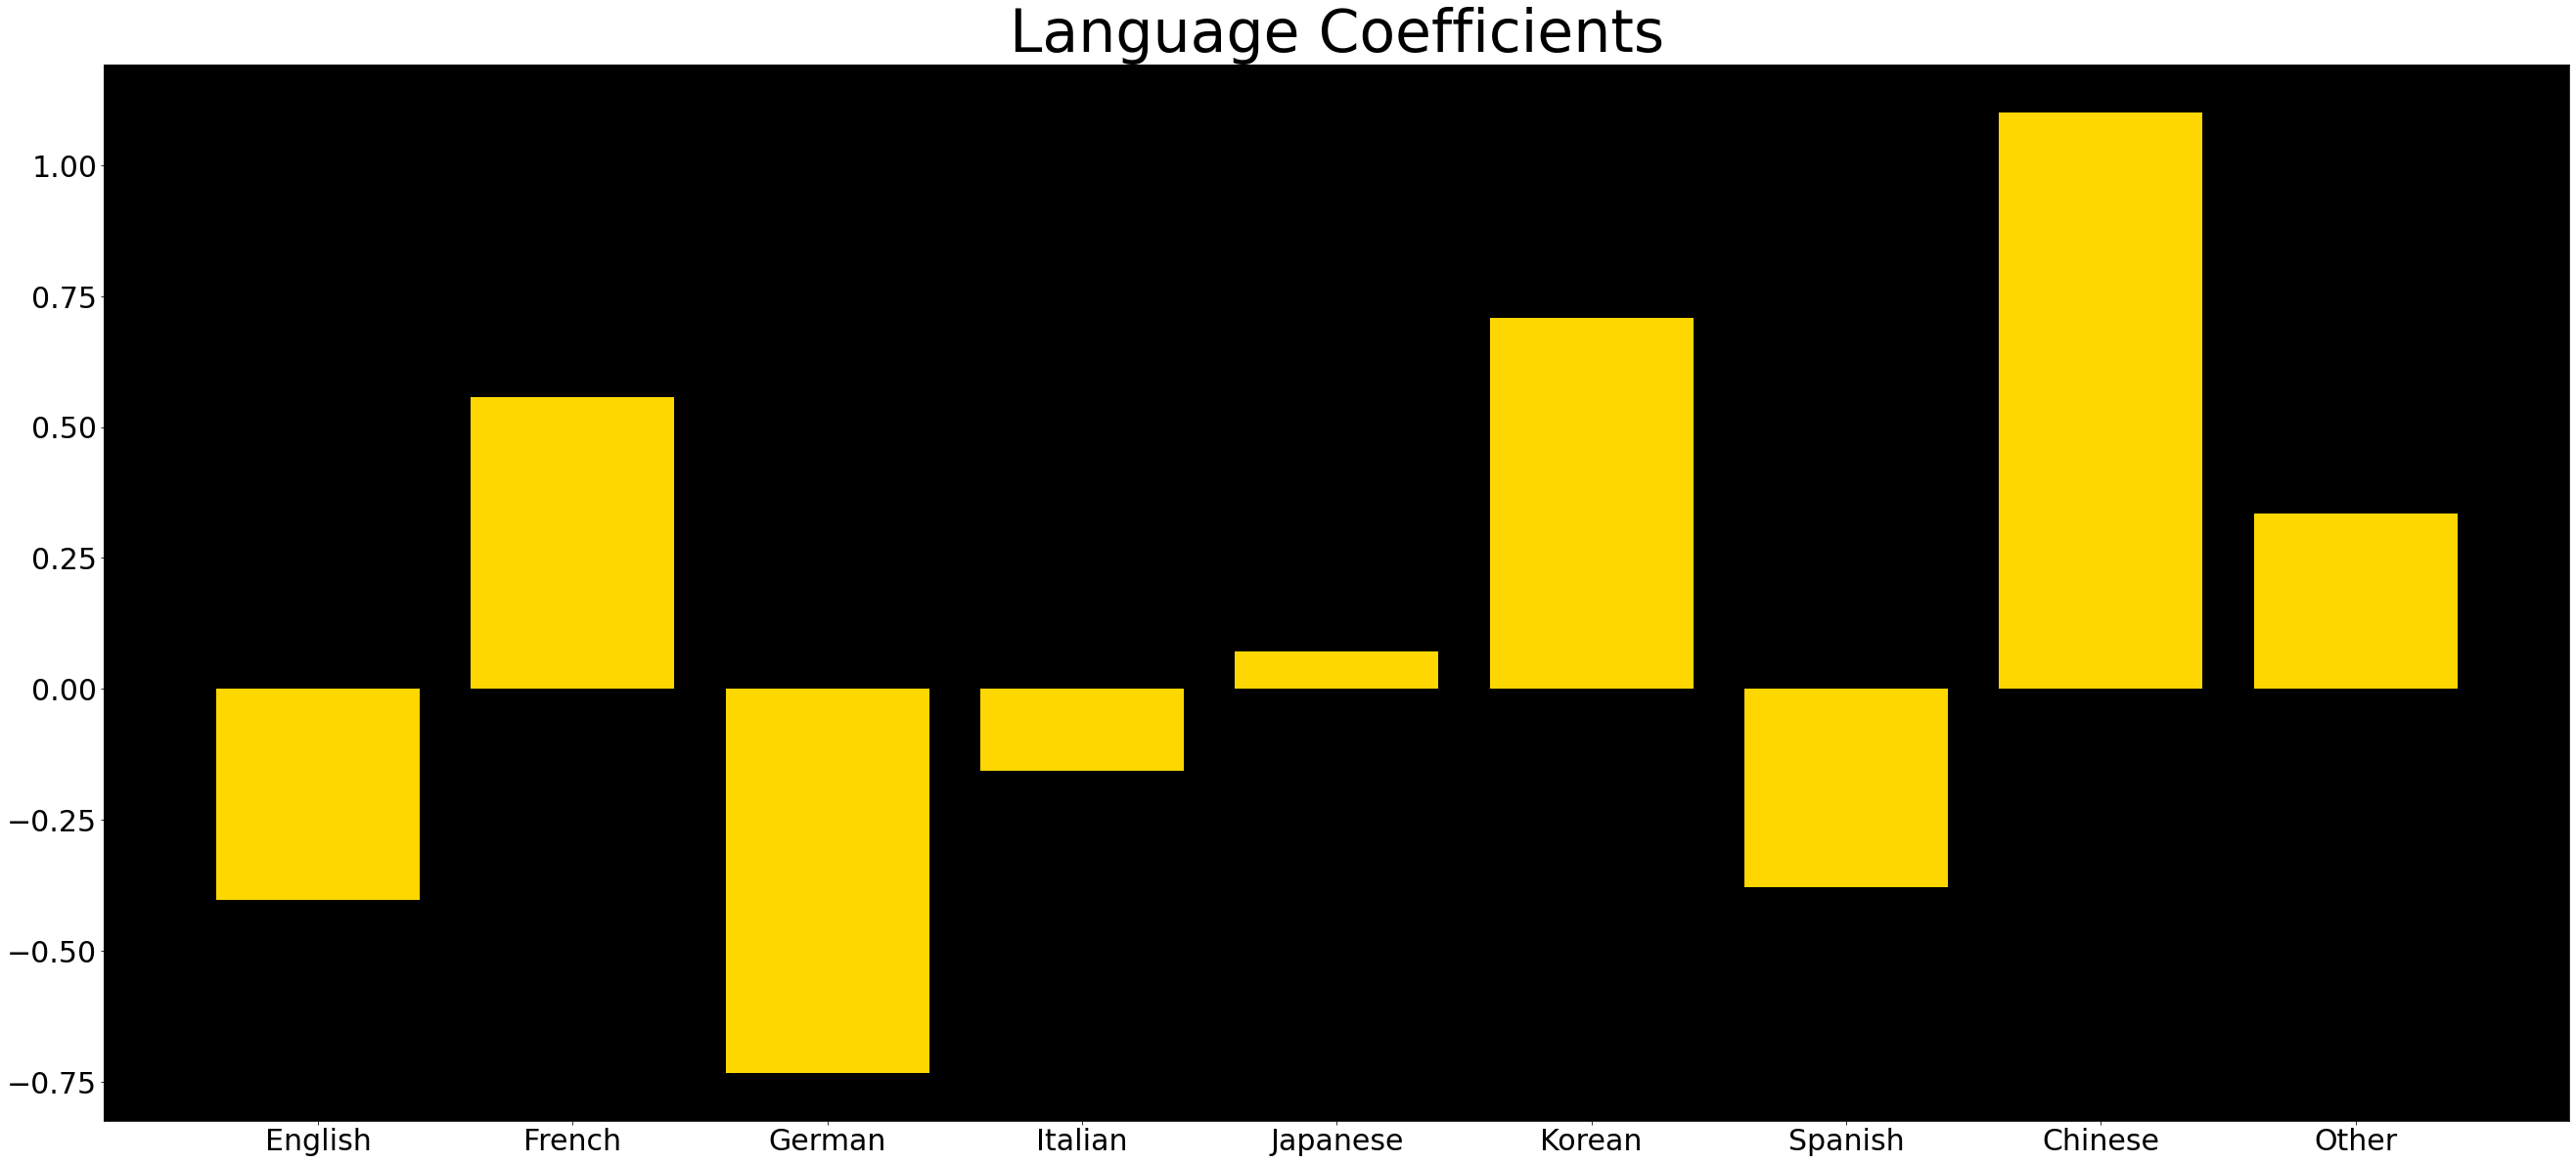

In [438]:
fig=plt.figure(figsize=(35,15))
ax=fig.add_axes([0,0,1,1])
ax.bar(coeffs_lang.index,coeffs_lang[0],color='gold')
ax.tick_params(axis='both', which='major', labelsize=30)
ax.set_facecolor('black')
ax.set_title('Language Coefficients',fontsize=60)

Text(0.5, 1.0, 'Other coefficients')

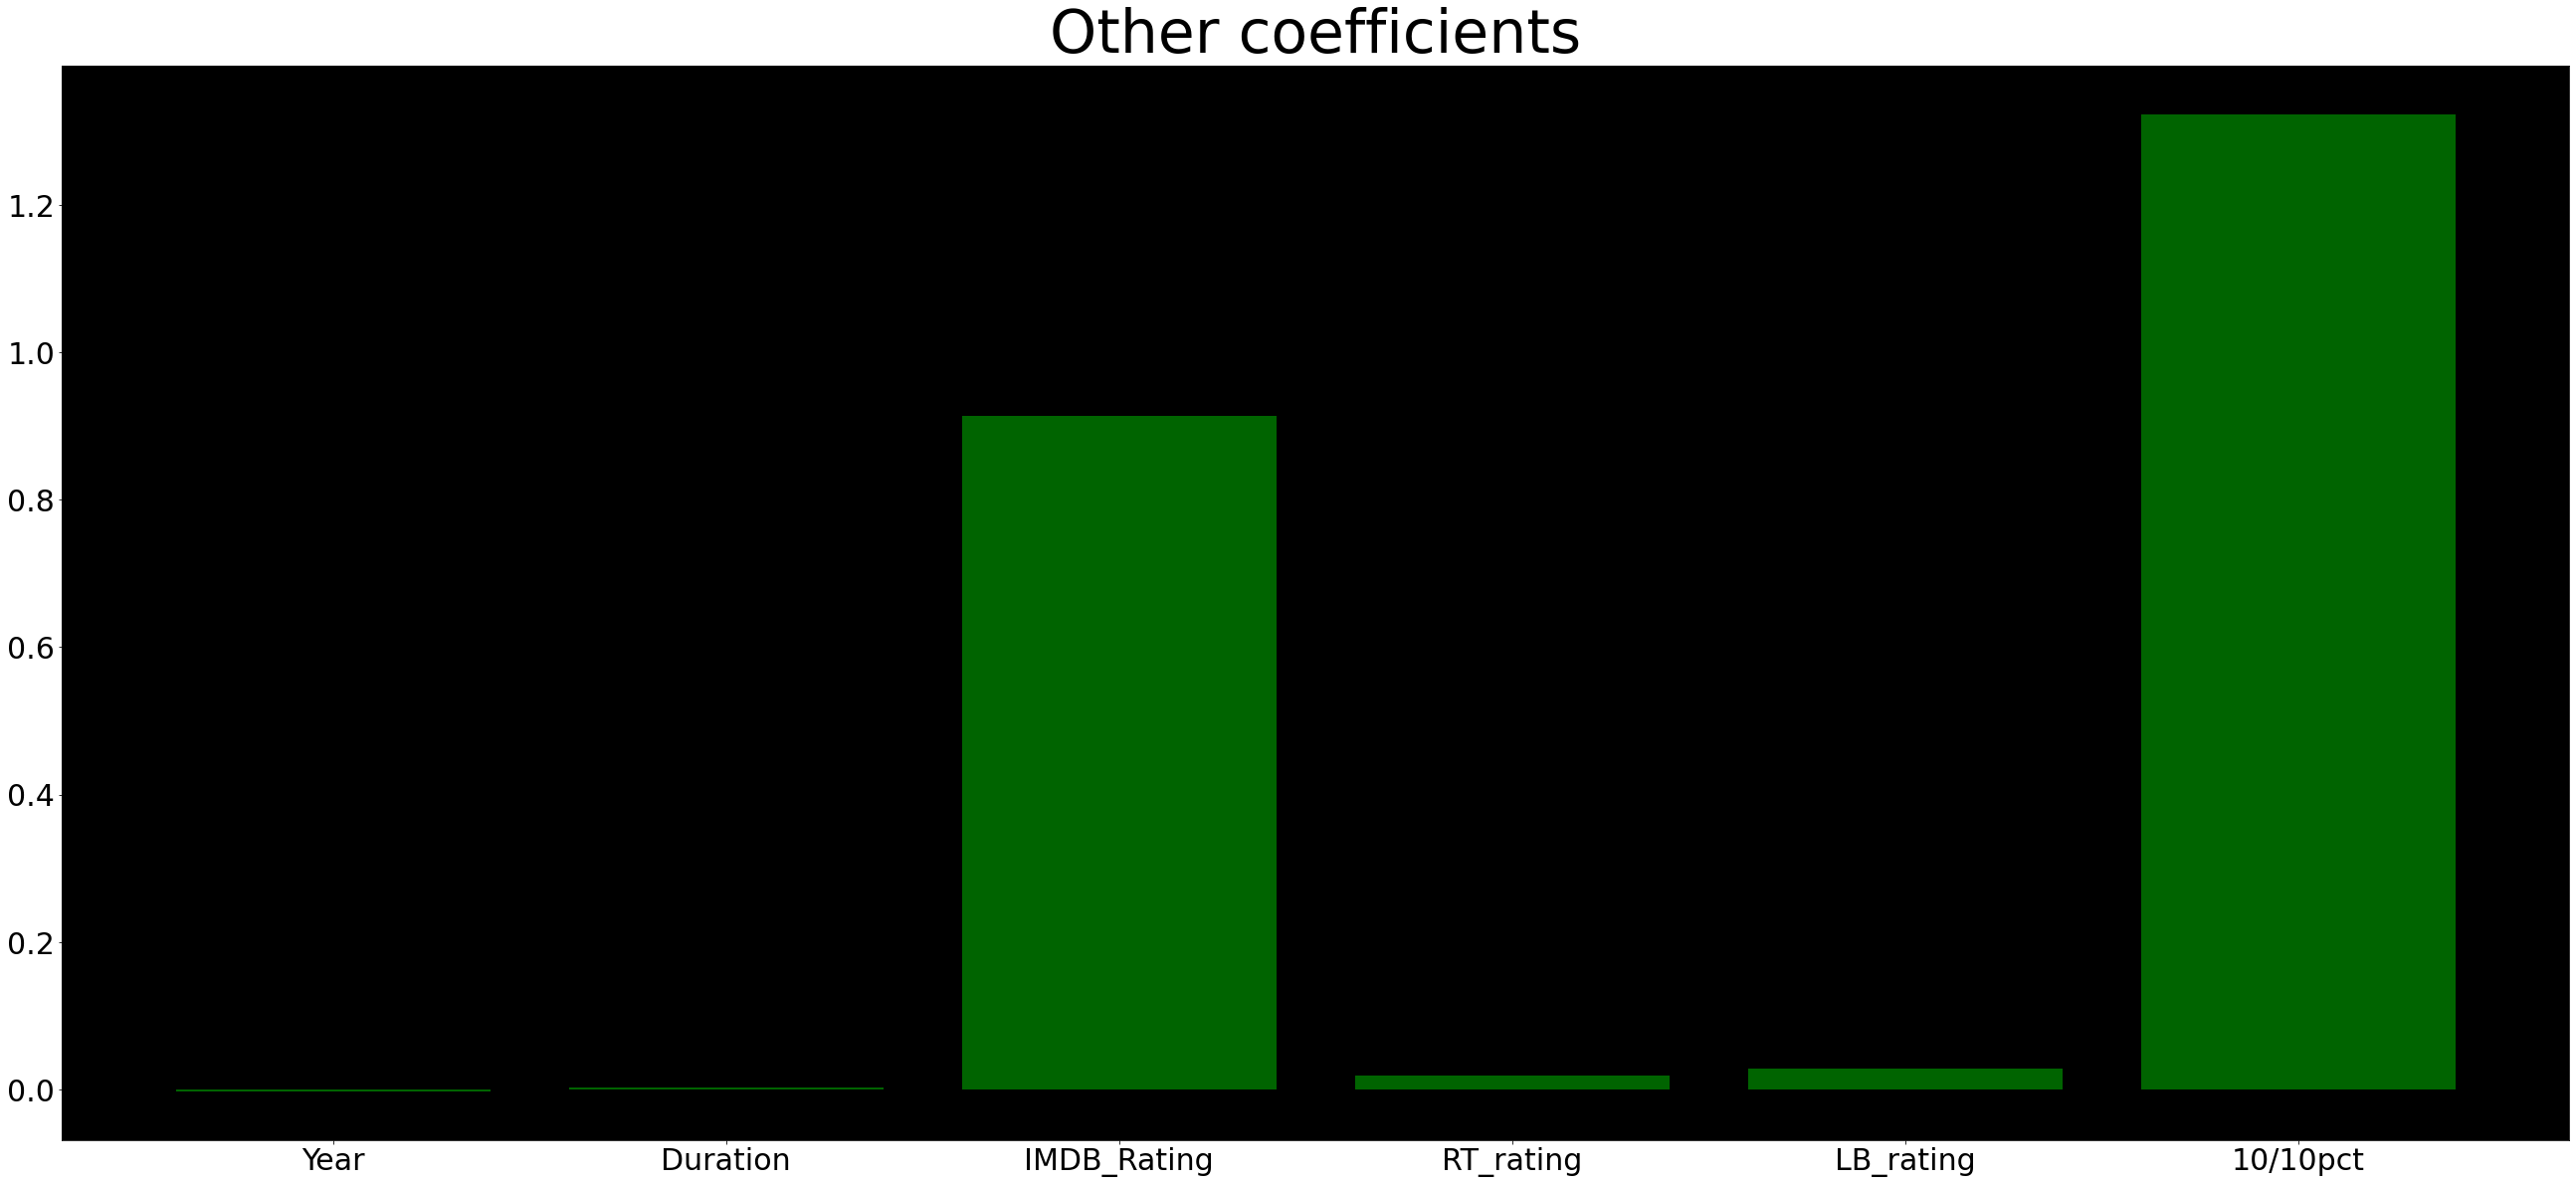

In [439]:
fig=plt.figure(figsize=(35,15))
ax=fig.add_axes([0,0,1,1])
ax.bar(coeffs_other.index,coeffs_other[0],color='darkgreen')
ax.tick_params(axis='both', which='major', labelsize=30)
ax.set_facecolor('black')
ax.set_title('Other coefficients',fontsize=60)

In [450]:
#fitdata regressing on with all variables, filtering out NA values on LB and RT when predicting
X=train[['Year', 'Duration','IMDB_Rating','10/10pct','RT_rating','LB_rating','Action','Adventure','Animation','Biography','Comedy','Crime','Drama','Family','Fantasy','Film-Noir','History',
         'Horror','Musical','Mystery','Romance','Sci-Fi','Sport','Thriller','War','Western','English','French','German', 'Italian', 'Japanese', 'Korean', 'Spanish', 'Chinese','Other']]
y=train[['My_Rating']]

lm=LinearRegression()
lm.fit(X,y)
print('RSquare:',lm.score(X,y))
print('Intercept:',lm.intercept_)

fitdata=mov[['Year', 'Duration','IMDB_Rating','10/10pct','RT_rating','LB_rating','Action','Adventure','Animation','Biography','Comedy','Crime','Drama','Family','Fantasy','Film-Noir','History',
         'Horror','Musical','Mystery','Romance','Sci-Fi','Sport','Thriller','War','Western','English','French','German', 'Italian', 'Japanese', 'Korean', 'Spanish', 'Chinese','Other']]
fitdata=fitdata.dropna()
fitted=lm.predict(fitdata)
movfiltered=mov[(mov['RT_rating'].isna()==False) & (mov['LB_rating'].isna()==False)]

RSquare: 0.41803012416457863
Intercept: [3.85418137]


In [451]:
movfiltered.insert(0,'Pred',fitted)
movfiltered=movfiltered[['Title','English_Title','Genre1','Year','Pred','My_Rating']]
movfiltered=movfiltered.sort_values('Pred',ascending=False)

In [453]:
#top 50 including one's i've rated
#movfiltered.head(50)
#Top 50 only new films
movfiltered[movfiltered['Genre1']=='Comedy'].head(50)

,Title,English_Title,Genre1,Year,Pred,My_Rating
239,GISAENGCHUNG,Parasite,Comedy,2019,10.309168,10.0
904,THE GREAT DICTATOR,The Great Dictator,Comedy,1940,9.165870,9.0
3460,THE FAREWELL,The Farewell,Comedy,2019,9.132975,NaN
141,LA VITA È BELLA,Life Is Beautiful,Comedy,1997,9.076056,10.0
4781,LA RÈGLE DU JEU,The Rules of the Game,Comedy,1939,9.067815,NaN
829,MODERN TIMES,Modern Times,Comedy,1936,8.890399,9.0
104,LE FABULEUX DESTIN D'AMÉLIE POULAIN,NaN,Comedy,2001,8.813640,8.0
1142,CITY LIGHTS,City Lights,Comedy,1931,8.795040,8.0
3196,STALAG 17,Stalag 17,Comedy,1953,8.651248,NaN
1173,THE APARTMENT,The Apartment,Comedy,1960,8.546445,9.0


In [454]:
#This is a second regression leaving out the RT and LB ratings. Allows me to get data to 5000 movies instead of ~3500 when they are included.
#However the values dont seem as good. best to use this to find movies that you can then add to your spreadsheet of missing values, and go back over the first regression
#consequently ill leave in the RT and LB columns to allow me to check where there is missing data on potentially high movies
X=train[['Year', 'Duration','IMDB_Rating','10/10pct','Action','Adventure','Animation','Biography','Comedy','Crime','Drama','Family','Fantasy','Film-Noir','History',
         'Horror','Musical','Mystery','Romance','Sci-Fi','Sport','Thriller','War','Western','English','French','German', 'Italian', 'Japanese', 'Korean', 'Spanish', 'Chinese','Other']]
y=train[['My_Rating']]

lm=LinearRegression()
lm.fit(X,y)
print('RSquare:',lm.score(X,y))
print('Intercept:',lm.intercept_)

fitdatall=mov[['Year', 'Duration','IMDB_Rating','10/10pct','Action','Adventure','Animation','Biography','Comedy','Crime','Drama','Family','Fantasy','Film-Noir','History',
         'Horror','Musical','Mystery','Romance','Sci-Fi','Sport','Thriller','War','Western','English','French','German', 'Italian', 'Japanese', 'Korean', 'Spanish', 'Chinese','Other']]
fittedall=lm.predict(fitdataall)
movfilteredall=mov.copy()

RSquare: 0.4117294482781262
Intercept: [5.30089808]


In [455]:
movfilteredall.insert(0,'Pred',fittedall)
movfilteredall=movfilteredall[['Title','English_Title','Genre1','Year','Pred','My_Rating','LB_rating','RT_rating']]
movfilteredall=movfilteredall.sort_values('Pred',ascending=False)

In [456]:
#top 50 including one's i've rated
#movfiltered.head(50)
#Top 50 only new films
movfilteredall[movfilteredall['My_Rating'].isna()].head(50)

,Title,English_Title,Genre1,Year,Pred,My_Rating,LB_rating,RT_rating
4969,BA WANG BIE JI,NaN,Drama,1993,10.467362,NaN,NaN,NaN
4921,THE BLUE ELEPHANT,NaN,Drama,2014,10.337655,NaN,NaN,NaN
4542,DÀ HÓNG DENGLONG GAOGAO GUÀ,NaN,Drama,1991,10.153664,NaN,NaN,NaN
2824,CHUNG HING SAM LAM,NaN,Comedy,1994,10.026724,NaN,NaN,NaN
1298,INCENDIES,Incendies,Drama,2010,10.021395,NaN,8.129063,9.3
2815,LES DIABOLIQUES,Diabolique,Crime,1955,9.909037,NaN,8.175189,9.6
2770,ESKIYA,NaN,Crime,1996,9.779283,NaN,NaN,NaN
4167,LA GRANDE ILLUSION,NaN,Drama,1937,9.754603,NaN,NaN,NaN
3022,UNDERGROUND,NaN,Comedy,1995,9.744044,NaN,NaN,8.6
4966,TUMBBAD,NaN,Drama,2018,9.742761,NaN,NaN,NaN
